In [1]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog


import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

from netCDF4 import num2date

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.q_vector.html

In [2]:
now = datetime.utcnow()
#now = datetime(2019, 3, 13, 0)
today_day = int('{0:%d}'.format(now))
today_month = int('{0:%m}'.format(now))
today_year = int('{0:%Y}'.format(now))
print(today_month,today_day,today_year)

forecast_times = []
for i in range(0,4):
    forecast_times.append(datetime(today_year,today_month,today_day,i*6,0))
for i in range(0,4):
    forecast_times.append(datetime(today_year,today_month,today_day+1,i*6,0))
#for i in range(0,8):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
#for i in range(0,8):
#    forecast_times.append(datetime(today_year,today_month,today_day+2,i*3,0))
#for i in range(0,8):
#    forecast_times.append(datetime(today_year,today_month,today_day+3,i*3,0))
forecast_times

4 10 2019


[datetime.datetime(2019, 4, 10, 0, 0),
 datetime.datetime(2019, 4, 10, 6, 0),
 datetime.datetime(2019, 4, 10, 12, 0),
 datetime.datetime(2019, 4, 10, 18, 0),
 datetime.datetime(2019, 4, 11, 0, 0),
 datetime.datetime(2019, 4, 11, 6, 0),
 datetime.datetime(2019, 4, 11, 12, 0),
 datetime.datetime(2019, 4, 11, 18, 0)]

In [3]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [4]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal()

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

In [5]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path = "/path/to/saved/files/"
im_save_path ="/Users/chowdahead/Desktop/Weather_Blog/"+'{0:%m_%d}'.format(now)+"/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

/Users/chowdahead/Desktop/Weather_Blog/04_10/


In [6]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[2]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2


In [7]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

subset_access = best.subset()
query = subset_access.query()

query.time(now)

query.variables('Temperature_isobaric', 'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
               'Apparent_temperature_height_above_ground',
               "Dewpoint_temperature_height_above_ground")
#230., 295., 15., 45.
#query.lonlat_box(west=230., east=295., south=15., north=45.)
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')
data = subset_access.get_data(query)

In [8]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
press = data.variables['isobaric'][:] * units.Pa
pressure_for_calc = press[:, None, None]
    
    
print(pressure_for_calc.shape)
dew = data.variables['Dewpoint_temperature_height_above_ground'][0] * units.kelvin
temperature = data.variables['Temperature_isobaric'][0] * units.kelvin
height = data.variables['Geopotential_height_isobaric'][0] * units.meter
u = data.variables['u-component_of_wind_isobaric'][0] * units.meter / units.second
v = data.variables['v-component_of_wind_isobaric'][0] * units.meter / units.second
temp = units.K * data.variables['Apparent_temperature_height_above_ground'][:].squeeze()

# Convert number of hours since the reference time into an actual date
time_var = data.variables[find_time_var(data.variables['Geopotential_height_isobaric'])]
time_final = num2date(time_var[:].squeeze(), time_var.units)
print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"    
    

(31, 1, 1)
2019_04_10_15Z


In [183]:
lat.shape, lon.shape

((101,), (161,))

In [184]:
mpcalc.lat_lon_grid_deltas?

In [185]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

print(dx.shape)
print(press.shape)
print(dy.shape)
print(temperature.shape)
print(u.shape)
print(v.shape)

(101, 160)
(31,)
(100, 161)
(31, 101, 161)
(31, 101, 161)
(31, 101, 161)


In [186]:
# metpy.calc.q_vector(u, v, temperature, pressure, dx, dy, static_stability=1)
Q = mpcalc.q_vector(u,v,temperature,pressure_for_calc,dx[0,:],dy[:,0])
Q = mpcalc.q_vector(u, v, temperature,pressure_for_calc, dx[None, :], dy[None, :])

In [187]:
print(Q[0].shape)
Q[1].shape

(31, 101, 161)


(31, 101, 161)

In [188]:
mpcalc.lat_lon_grid_deltas?

In [189]:
dx.shape,dy.shape

((101, 160), (100, 161))

In [190]:
print(dx[:,0].shape,dy[0,:].shape)
print(pressure_for_calc.shape)
print(temperature.shape)

(101,) (161,)
(31, 1, 1)
(31, 101, 161)


ok.


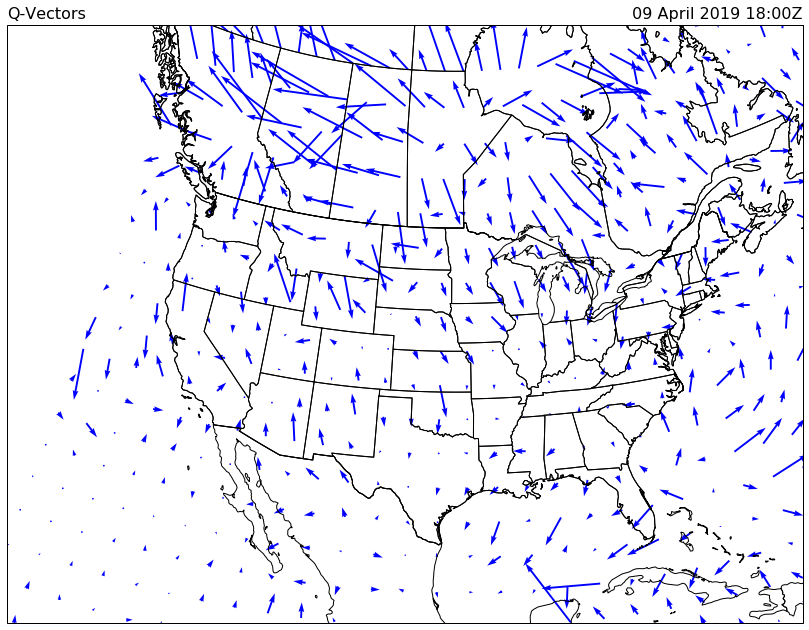

In [191]:
# Create a plot
fig = plt.figure(figsize=(17., 11.))

add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    
# Plot Title
plt.title('Q-Vectors',loc='left',fontsize=16)
plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)



                                            # Isentropic Winds
#---------------------------------------------------------------------------------------------------
print("ok.")
lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
#lon[lon_slice], lat[lat_slice],
#         isen_u[lon_slice, lat_slice],
#         isen_v[lon_slice, lat_slice],
lon_2d, lat_2d = np.meshgrid(lon, lat)
#ax.barbs(lon,lat,Q[0][0,:,:], Q[1][0,:,:], 
#         transform=ccrs.PlateCarree(), zorder=3,barbcolor='k')
#ax.quiver(lon[lon_slice],lat[lat_slice],Q[0][0,lon_slice,lat_slice], Q[1][0,lon_slice,lat_slice],color='k',
#          transform=plotcrs)


#ax.quiver(lon[110],lat[40],Q[0][0,40,11], Q[1][0,40,11],color='r',transform=plotcrs)
#ax.quiver(lon[110],lat[40],Q[0][0,40,110], Q[1][0,40,110],transform=plotcrs,color='r')

#ax.quiver(lon[112],lat[32],Q[0][0,32,112], Q[1][0,32,112],transform=plotcrs)
clevtemp = np.arange(-30, 90, .5)

# Uncomment for contours instead of contour fill (below)
#cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
#                 cmap='gist_rainbow_r', linewidths=1.25,
#                 transform=datacrs)  #linestyles='dotted'

#cs2 = ax.contour(lon, lat, temp.to(units('degF')),40,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

#cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

#cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)


#cs2 = ax.contour(lon, lat, theta_e[30],100,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

#cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

#cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)



ax.quiver(lon[lon_slice], lat[lat_slice],
          Q[0][0,lon_slice,lat_slice].m, Q[1][0,lon_slice,lat_slice].m,
          color='b', transform=ccrs.PlateCarree())

                                           # Isentropic Mixing Ratio
#---------------------------------------------------------------------------------------------------

ax.set_extent(extent, datacrs)

#cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
#cbar = plt.colorbar(cntr2, orientation='horizontal',cax=cbaxes)

plt.show()


#GFS_Isentrope = im_save_path+"GFS/Isentropes_MixRatio/"
#if not os.path.isdir(GFS_Isentrope):
#os.makedirs(GFS_Isentrope)
fig.savefig("/Users/chowdahead/Desktop/Q-vectors.png",bbox_inches='tight',dpi=120)
#plt.close(fig)

In [19]:
ax.barbs?

In [20]:
len(Q)

2

In [21]:
print(dx[:,0].shape,dy[0,:].shape)
print(lat.shape,lon.shape)
print(Q[0][0,:,:].shape)
print(Q[1][0,:,:].shape)

(101,) (161,)
(101,) (161,)
(101, 161)
(101, 161)


In [22]:
dx[:,0][0]
#lon[0]

<Quantity(27798.652415045286, 'meter')>

In [23]:
Q[0][0,:,:][0][0]

<Quantity(-6.036431997617722e-10, 'meter ** 2 / kilogram / second')>

In [24]:
Q[0][0,0,0]

<Quantity(-6.036431997617722e-10, 'meter ** 2 / kilogram / second')>

In [30]:
plotcrs

In [33]:
datacrs

In [26]:
lat[40],180-lon[110]

(40.0, -105.0)

In [27]:
len(lon)

161

In [32]:
print(Q[1][0,40,110])
Q[1][0,40,110].m

4.519550642180962e-11 meter ** 2 / kilogram / second


4.519550642180962e-11

In [68]:
list(pressure_for_calc[:])

[<Quantity([[100.]], 'pascal')>,
 <Quantity([[200.]], 'pascal')>,
 <Quantity([[300.]], 'pascal')>,
 <Quantity([[500.]], 'pascal')>,
 <Quantity([[700.]], 'pascal')>,
 <Quantity([[1000.]], 'pascal')>,
 <Quantity([[2000.]], 'pascal')>,
 <Quantity([[3000.]], 'pascal')>,
 <Quantity([[5000.]], 'pascal')>,
 <Quantity([[7000.]], 'pascal')>,
 <Quantity([[10000.]], 'pascal')>,
 <Quantity([[15000.]], 'pascal')>,
 <Quantity([[20000.]], 'pascal')>,
 <Quantity([[25000.]], 'pascal')>,
 <Quantity([[30000.]], 'pascal')>,
 <Quantity([[35000.]], 'pascal')>,
 <Quantity([[40000.]], 'pascal')>,
 <Quantity([[45000.]], 'pascal')>,
 <Quantity([[50000.]], 'pascal')>,
 <Quantity([[55000.]], 'pascal')>,
 <Quantity([[60000.]], 'pascal')>,
 <Quantity([[65000.]], 'pascal')>,
 <Quantity([[70000.]], 'pascal')>,
 <Quantity([[75000.]], 'pascal')>,
 <Quantity([[80000.]], 'pascal')>,
 <Quantity([[85000.]], 'pascal')>,
 <Quantity([[90000.]], 'pascal')>,
 <Quantity([[92500.]], 'pascal')>,
 <Quantity([[95000.]], 'pascal')>,


In [37]:
theta_e = mpcalc.equivalent_potential_temperature(pressure_for_calc, temperature,dew)

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:6667: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [47]:
theta_e.shape

(31, 101, 161)

In [57]:
theta_e[30][0:40]

<Quantity([[289.04534912109375 291.1377258300781 292.8683776855469 ...
  287.62091064453125 288.06353759765625 288.3714294433594]
 [287.2010803222656 289.2831115722656 290.6492614746094 ...
  287.9046630859375 288.11456298828125 288.08404541015625]
 [288.4268493652344 288.9812927246094 289.41754150390625 ...
  287.7845764160156 288.0424499511719 288.2247619628906]
 ...
 [301.8678283691406 301.3944091796875 301.3767395019531 ...
  286.8240966796875 286.2888488769531 285.44171142578125]
 [302.6069030761719 302.6069030761719 302.584716796875 ...
  289.551025390625 289.9066162109375 289.6114501953125]
 [303.6883544921875 303.8509826660156 304.0980529785156 ...
  291.9580383300781 292.5325927734375 293.0104064941406]], 'kelvin')>

In [29]:
# metpy.calc.equivalent_potential_temperature(pressure, temperature, dewpoint)
# metpy.calc.frontogenesis(thta, u, v, dx, dy, dim_order='yx')

In [ ]:
metpy.calc.frontogenesis(thta, u, v, dx, dy, dim_order='yx')


In [234]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[2]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190409_1800.grib2


In [235]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

subset_access = best.subset()
query = subset_access.query()

query.time(now)

query.variables("Potential_temperature_sigma",
               "u-component_of_wind_sigma","v-component_of_wind_sigma")
#230., 295., 15., 45.
#query.lonlat_box(west=230., east=295., south=15., north=45.)
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')
data = subset_access.get_data(query)

In [236]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

#theta = data.variables['Potential_temperature_sigma'][0] * units.kelvin
u = data.variables['u-component_of_wind_sigma'][0] * units.meter / units.second
v = data.variables['v-component_of_wind_sigma'][0] * units.meter / units.second


In [237]:
theta = mpcalc.potential_temperature(pressure_for_calc, temperature)

In [238]:
Fronto = mpcalc.frontogenesis(theta, u, v, dx[None, :], dy[None, :])


/Users/chowdahead/miniconda3/lib/python3.7/site-packages/pint/quantity.py:802: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/pint/quantity.py:802: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/metpy/calc/kinematics.py:397: RuntimeWarning: invalid value encountered in arcsin
  beta = np.arcsin((-ddx_thta * np.cos(psi) - ddy_thta * np.sin(psi)) / mag_thta)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/pint/quantity.py:1403: RuntimeWarning: invalid value encountered in arcsin
  out = uf(*mobjs)


In [239]:
Fronto.shape

(31, 101, 161)

In [197]:
import Color_Bar

In [198]:
colors = [(70,0,0),(150,0,0),(180,0,0),(255,255,255),(255,255,255),
          
          (200,200,200),(100,100,230),
          (0,10,230),(0,10,200),(0,10,195),(0,10,190),(0,10,180),(0,10,170),(0,10,150),
          (0,10,120),(0,0,100),(0,0,60),(0,0,50)]

vort_cmap = Color_Bar.create_colormap(colors, bit=True)

ok.


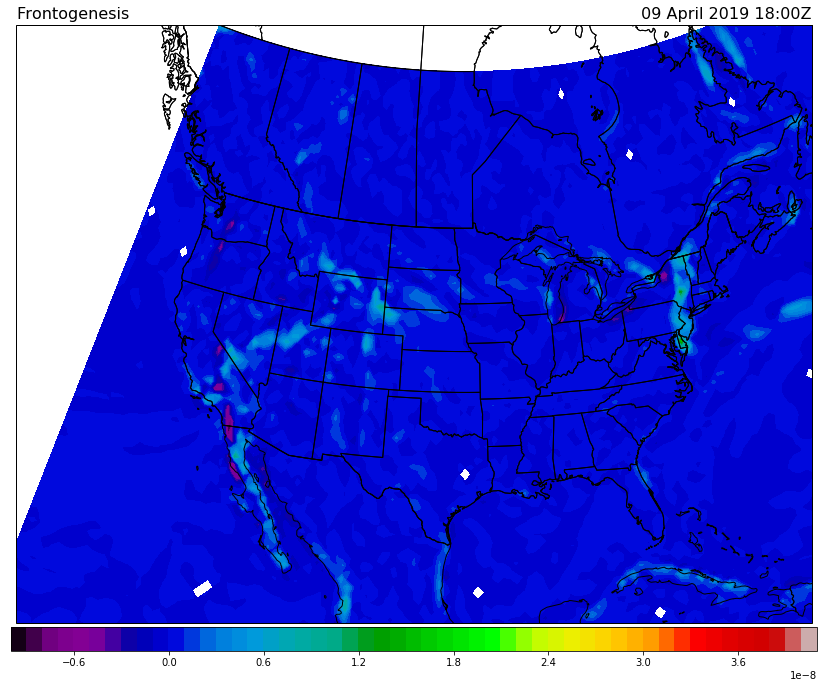

In [248]:
# Create a plot
fig = plt.figure(figsize=(17., 11.))

add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    
# Plot Title
plt.title('Frontogenesis',loc='left',fontsize=16)
plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)



                                            # Isentropic Winds
#---------------------------------------------------------------------------------------------------
print("ok.")
lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
#lon[lon_slice], lat[lat_slice],
#         isen_u[lon_slice, lat_slice],
#         isen_v[lon_slice, lat_slice],
lon_2d, lat_2d = np.meshgrid(lon, lat)
#ax.barbs(lon,lat,Q[0][0,:,:], Q[1][0,:,:], 
#         transform=ccrs.PlateCarree(), zorder=3,barbcolor='k')
#ax.quiver(lon[lon_slice],lat[lat_slice],Q[0][0,lon_slice,lat_slice], Q[1][0,lon_slice,lat_slice],color='k',
#          transform=plotcrs)


#ax.quiver(lon[110],lat[40],Q[0][0,40,11], Q[1][0,40,11],color='r',transform=plotcrs)
#ax.quiver(lon[110],lat[40],Q[0][0,40,110], Q[1][0,40,110],transform=plotcrs,color='r')

#ax.quiver(lon[112],lat[32],Q[0][0,32,112], Q[1][0,32,112],transform=plotcrs)
#clev = np.arange(Fronto.min().m,Fronto.max().m, .0000000001)

# Uncomment for contours instead of contour fill (below)
#cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
#                 cmap='gist_rainbow_r', linewidths=1.25,
#                 transform=datacrs)  #linestyles='dotted'

#cs2 = ax.contour(lon, lat, temp.to(units('degF')),40,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

#cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

#cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)

lev = np.arange(-1e-8,4.2e-8,.1e-8)
cs2 = ax.contourf(lon, lat, Fronto[30,:,:],lev,
                 transform=datacrs,cmap='nipy_spectral') #'nipy_spectral'


ax.set_extent(extent, datacrs)

cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)

plt.show()


#GFS_Isentrope = im_save_path+"GFS/Isentropes_MixRatio/"
#if not os.path.isdir(GFS_Isentrope):
#os.makedirs(GFS_Isentrope)
fig.savefig("/Users/chowdahead/Desktop/fronto.png",bbox_inches='tight',dpi=120)
#plt.close(fig)

In [242]:
Fronto[0][0].max().m

5.727828039004219e-09

In [220]:
Fronto.max(),Fronto.min().m

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


(<Quantity(nan, 'kelvin / meter / second')>, nan)

In [125]:
theta[30][0]

<Quantity([280.5907897949219 281.6907958984375 283.0907897949219 283.5907897949219
 283.6907958984375 283.6907958984375 283.6907958984375 283.5907897949219
 283.2908020019531 283.5907897949219 284.1907958984375 285.0907897949219
 285.7908020019531 285.5907897949219 285.5907897949219 285.39080810546875
 285.1907958984375 284.89080810546875 284.5907897949219 284.39080810546875
 284.49078369140625 284.2908020019531 284.1907958984375 284.39080810546875
 284.49078369140625 284.89080810546875 285.7908020019531
 285.39080810546875 285.2908020019531 284.5907897949219 284.39080810546875
 284.7908020019531 284.1907958984375 281.7908020019531 279.49078369140625
 277.99078369140625 276.6907958984375 275.1907958984375 273.99078369140625
 273.2908020019531 272.99078369140625 272.6907958984375 272.49078369140625
 272.49078369140625 272.39080810546875 272.2908020019531 272.0907897949219
 271.99078369140625 271.99078369140625 271.7908020019531 271.0907897949219
 270.1907958984375 269.5907897949219 269.0907897949219 268.5907897949219
 267.99078369140625 267.0907897949219 266.2908020019531 265.99078369140625
 265.2908020019531 264.1907958984375 262.89080810546875 261.0907897949219
 259.2908020019531 258.1907958984375 257.49078369140625 257.2908020019531
 257.49078369140625 257.5907897949219 257.99078369140625
 257.99078369140625 257.99078369140625 257.99078369140625
 257.89080810546875 257.89080810546875 257.7908020019531 257.6907958984375
 257.6907958984375 257.5907897949219 257.49078369140625 257.49078369140625
 257.39080810546875 257.39080810546875 257.39080810546875
 257.39080810546875 257.39080810546875 257.39080810546875
 257.49078369140625 257.49078369140625 257.39080810546875
 257.2908020019531 257.1907958984375 256.99078369140625 256.99078369140625
 256.99078369140625 257.0907897949219 257.0907897949219 256.99078369140625
 256.89080810546875 256.6907958984375 256.39080810546875 256.1907958984375
 256.1907958984375 256.49078369140625 257.0907897949219 257.7908020019531
 258.1907958984375 258.5907897949219 258.89080810546875 259.0907897949219
 259.99078369140625 260.1907958984375 260.5907897949219 260.5907897949219
 260.2908020019531 260.49078369140625 260.99078369140625
 261.39080810546875 261.1907958984375 260.6907958984375 260.6907958984375
 260.89080810546875 260.99078369140625 260.5907897949219 260.0907897949219
 259.2908020019531 258.6907958984375 258.0907897949219 256.99078369140625
 256.0907897949219 256.5907897949219 256.99078369140625 260.1907958984375
 259.2908020019531 258.5907897949219 257.99078369140625 257.89080810546875
 259.39080810546875 262.5907897949219 266.39080810546875 269.2908020019531
 270.99078369140625 272.0907897949219 272.7908020019531 272.99078369140625
 273.1907958984375 273.49078369140625 273.7908020019531 274.0907897949219
 274.39080810546875 274.5907897949219 274.7908020019531 275.0907897949219
 275.49078369140625 275.89080810546875 276.1907958984375
 276.39080810546875 276.5907897949219 276.99078369140625 277.6907958984375
 278.39080810546875], 'kelvin')>

In [9]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[2]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2


In [10]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

subset_access = best.subset()
query = subset_access.query()

query.time(now)

query.variables("Convective_available_potential_energy_surface")
#230., 295., 15., 45.
#query.lonlat_box(west=230., east=295., south=15., north=45.)
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')
data = subset_access.get_data(query)

In [13]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

cape = data.variables['Convective_available_potential_energy_surface'][0]

# Convert number of hours since the reference time into an actual date
time_var = data.variables[find_time_var(data.variables['Convective_available_potential_energy_surface'])]
time_final = num2date(time_var[:].squeeze(), time_var.units)
print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"    
    

2019_04_10_15Z


ok.


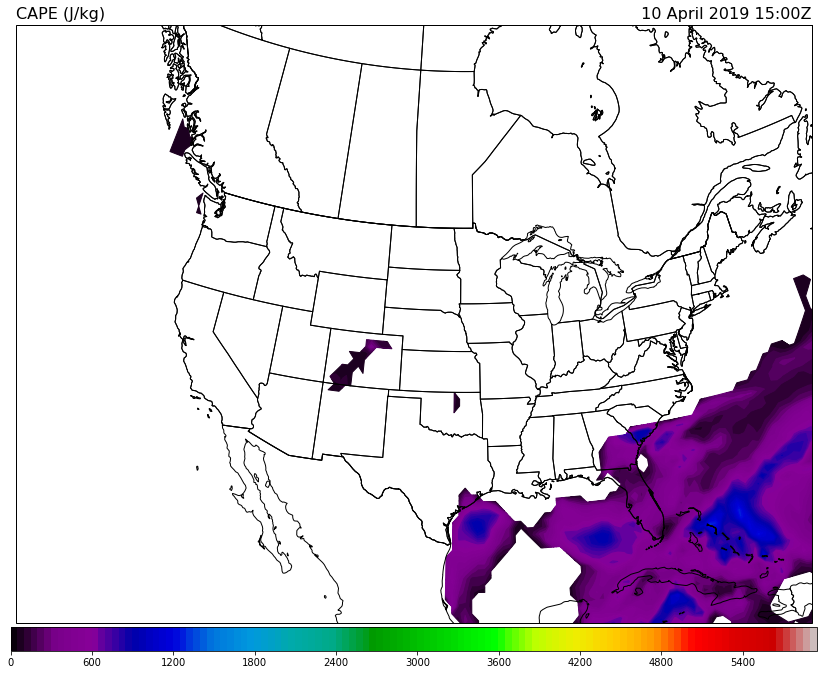

In [14]:
# Create a plot
fig = plt.figure(figsize=(17., 11.))

add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    
# Plot Title
plt.title('CAPE (J/kg)',loc='left',fontsize=16)
plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)



                                            # Isentropic Winds
#---------------------------------------------------------------------------------------------------
print("ok.")
lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
#lon[lon_slice], lat[lat_slice],
#         isen_u[lon_slice, lat_slice],
#         isen_v[lon_slice, lat_slice],
lon_2d, lat_2d = np.meshgrid(lon, lat)
#ax.barbs(lon,lat,Q[0][0,:,:], Q[1][0,:,:], 
#         transform=ccrs.PlateCarree(), zorder=3,barbcolor='k')
#ax.quiver(lon[lon_slice],lat[lat_slice],Q[0][0,lon_slice,lat_slice], Q[1][0,lon_slice,lat_slice],color='k',
#          transform=plotcrs)


#ax.quiver(lon[110],lat[40],Q[0][0,40,11], Q[1][0,40,11],color='r',transform=plotcrs)
#ax.quiver(lon[110],lat[40],Q[0][0,40,110], Q[1][0,40,110],transform=plotcrs,color='r')

#ax.quiver(lon[112],lat[32],Q[0][0,32,112], Q[1][0,32,112],transform=plotcrs)
#clev = np.arange(Fronto.min().m,Fronto.max().m, .0000000001)

# Uncomment for contours instead of contour fill (below)
#cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
#                 cmap='gist_rainbow_r', linewidths=1.25,
#                 transform=datacrs)  #linestyles='dotted'

#cs2 = ax.contour(lon, lat, temp.to(units('degF')),40,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

#cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
lev = np.arange(0,6000,50)
#cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)
cape = np.ma.masked_where(cape < 50.,cape)
cs2 = ax.contourf(lon, lat, cape,lev,
                 transform=datacrs,cmap='nipy_spectral',alpha=0.5,antialiased=True) #'nipy_spectral'
cs2 = ax.contourf(lon, lat, cape,lev,
                 transform=datacrs,cmap='nipy_spectral',antialiased=True) #'nipy_spectral'
#cs2 = plt.pcolormesh(lon, lat, cape,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)
for c in cs2.collections:
    c.set_edgecolor("face")

ax.set_extent(extent, datacrs)

cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)

plt.show()


#GFS_Isentrope = im_save_path+"GFS/Isentropes_MixRatio/"
#if not os.path.isdir(GFS_Isentrope):
#os.makedirs(GFS_Isentrope)
fig.savefig("/Users/chowdahead/Desktop/cape_"+file_time+".png",bbox_inches='tight',dpi=120)
#plt.close(fig)

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_10_00Z
ok.


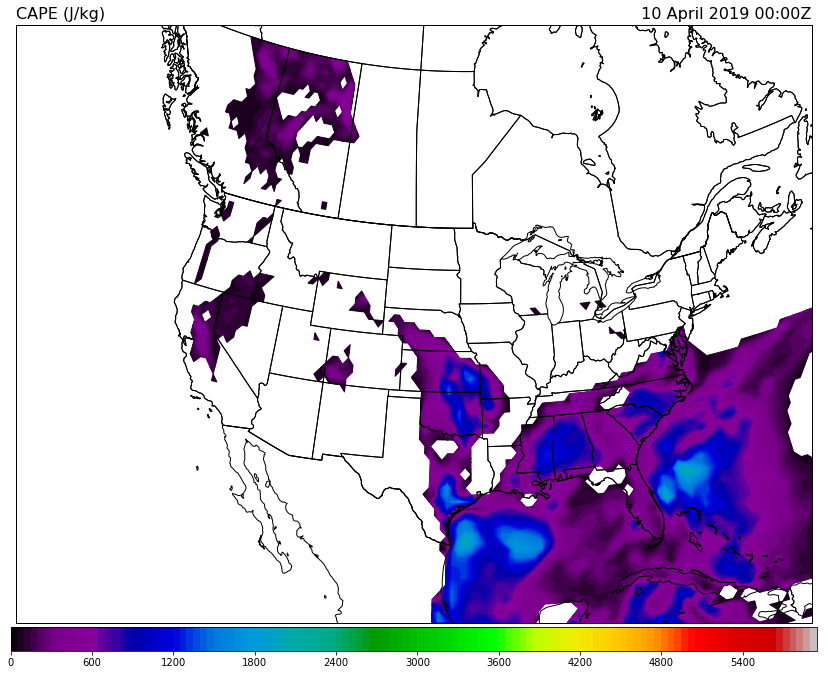

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_10_06Z
ok.


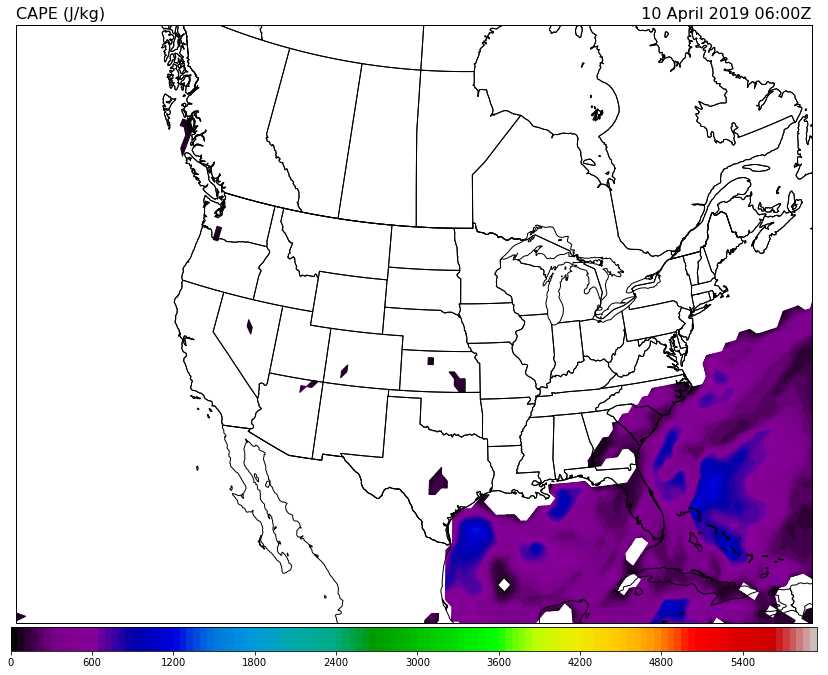

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_10_12Z
ok.


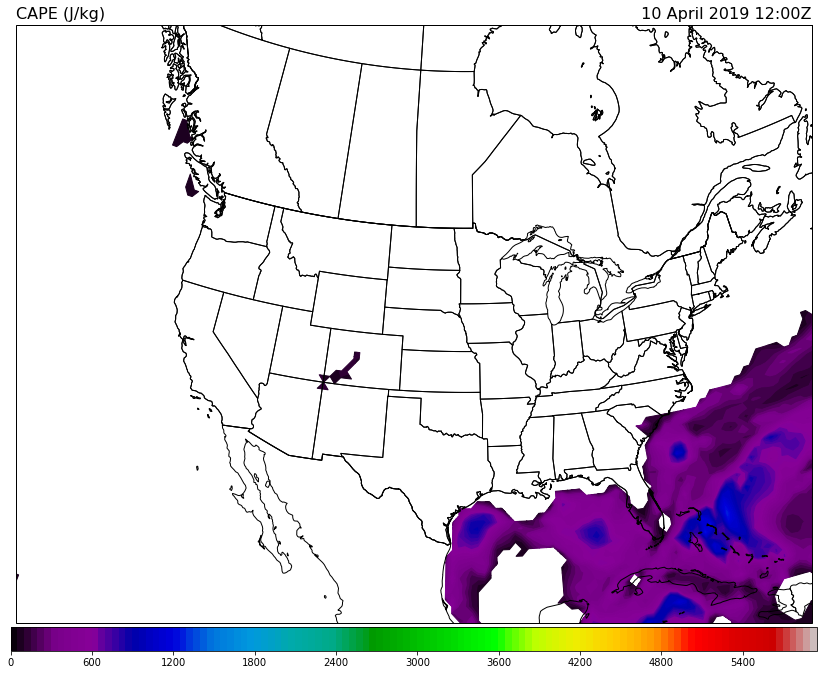

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_10_18Z
ok.


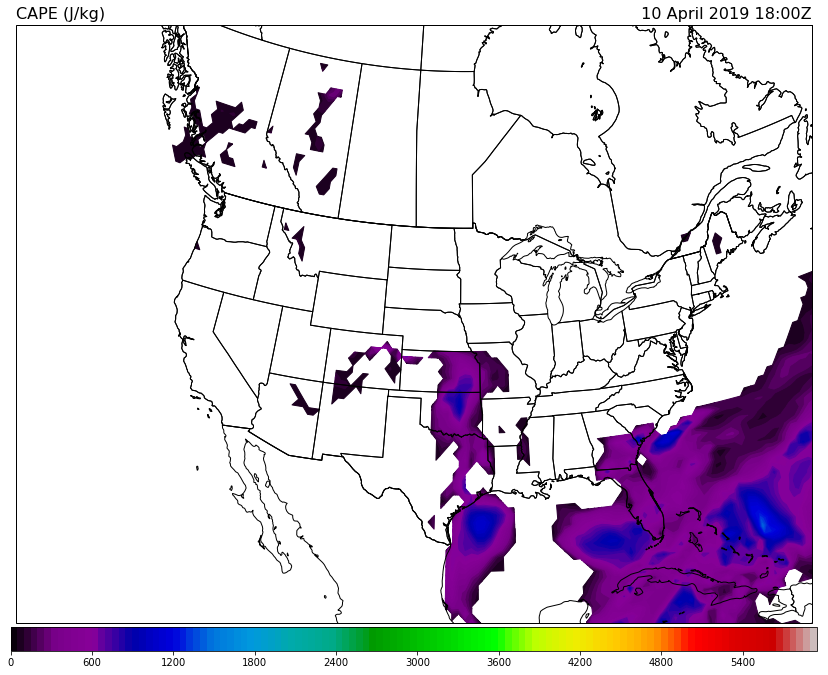

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_11_00Z
ok.


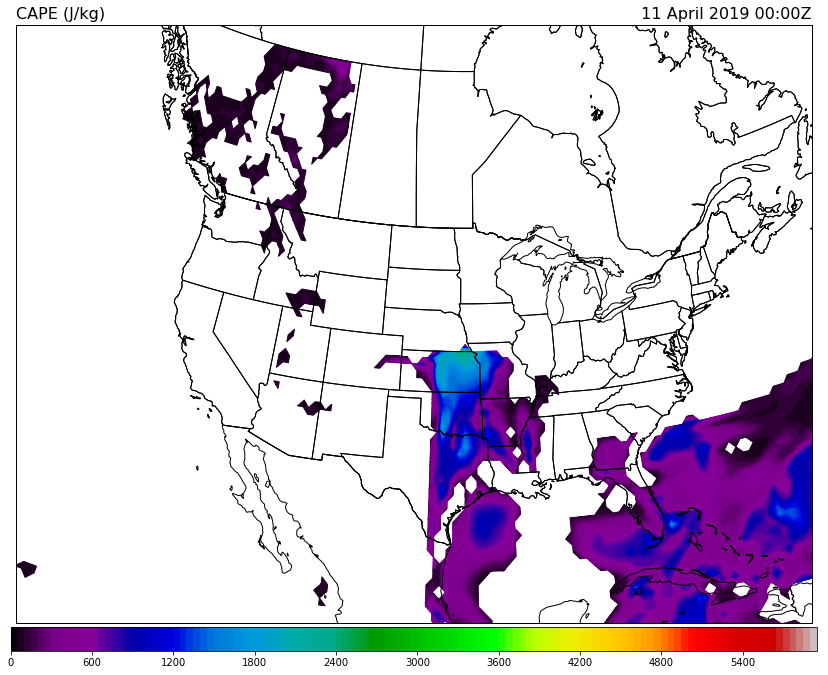

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_11_06Z
ok.


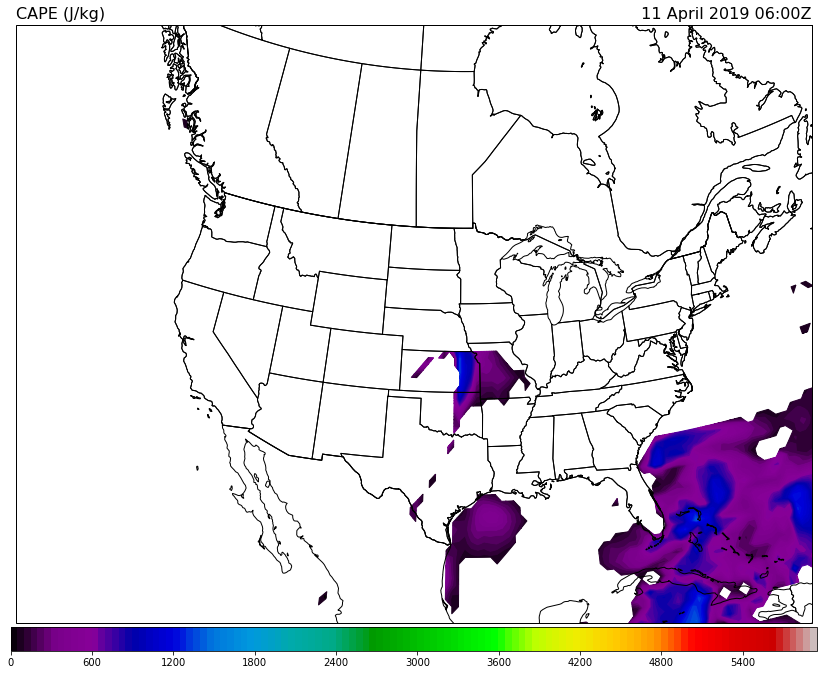

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_11_12Z
ok.


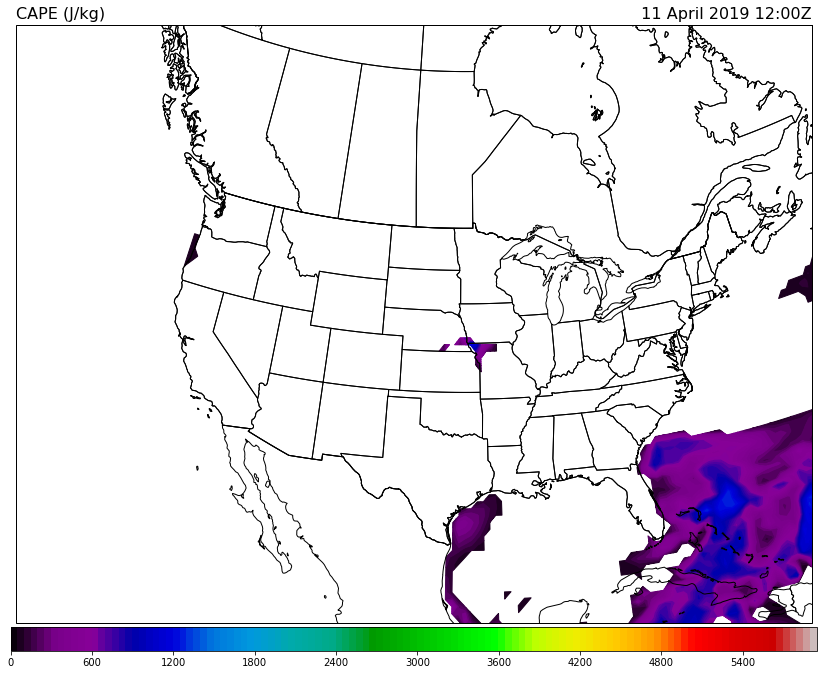

Variable Name: Latest Collection for GFS Quarter Degree Forecast
Path: grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190410_0600.grib2
2019_04_11_18Z
ok.


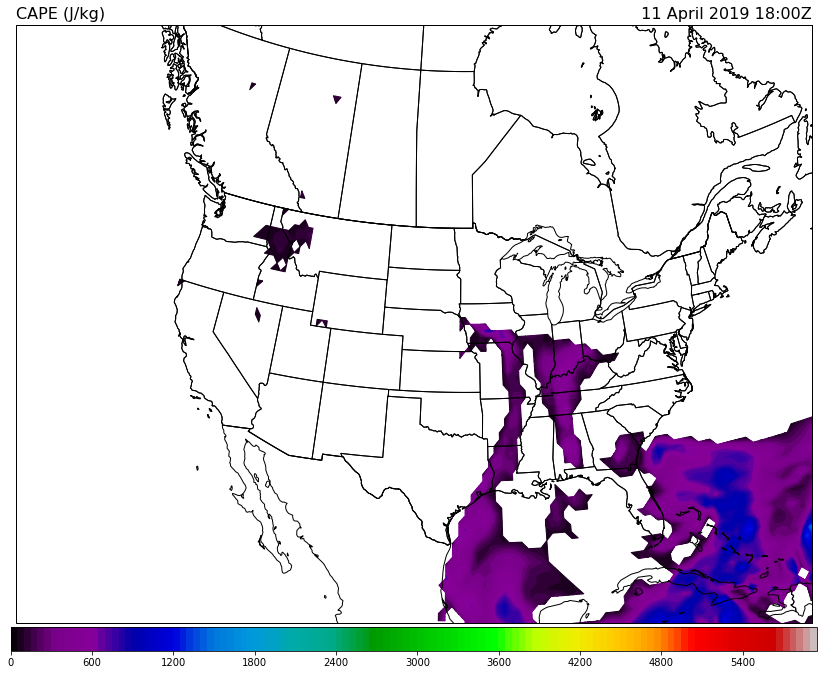

In [15]:
for i in forecast_times:
    from siphon.catalog import TDSCatalog
    top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
    ref = top_cat.catalog_refs['Forecast Model Data']
    new_cat = ref.follow()
    model = new_cat.catalog_refs[4]
    gfs_cat = model.follow()
    ds = gfs_cat.datasets[2]
    print("Variable Name:",ds.name)
    print("Path:",ds.url_path)

    cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                     'NCEP/GFS/Global_0p5deg/catalog.xml')
    best = cat.datasets['Best GFS Half Degree Forecast Time Series']

    subset_access = best.subset()
    query = subset_access.query()

    query.time(i)

    query.variables("Convective_available_potential_energy_surface")
    #230., 295., 15., 45.
    #query.lonlat_box(west=230., east=295., south=15., north=45.)
    query.lonlat_box(west=-130, east=-50, south=10, north=60)
    query.accept('netcdf4')
    data = subset_access.get_data(query)

    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]

    cape = data.variables['Convective_available_potential_energy_surface'][0]

    # Convert number of hours since the reference time into an actual date
    time_var = data.variables[find_time_var(data.variables['Convective_available_potential_energy_surface'])]
    time_final = num2date(time_var[:].squeeze(), time_var.units)
    print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
    file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"    

    # Create a plot
    fig = plt.figure(figsize=(17., 11.))

    add_metpy_logo(fig, 30, 940, size='small')

    # Add the map and set the extent
    ax = plt.subplot(111, projection=plotcrs)

    # Add state boundaries to plot
    ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

    # Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)

    # Plot Title
    plt.title('CAPE (J/kg)',loc='left',fontsize=16)
    plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)



                                                # Isentropic Winds
    #---------------------------------------------------------------------------------------------------
    print("ok.")
    lon_slice = slice(None, None, 5)
    lat_slice = slice(None, None, 5)
    #lon[lon_slice], lat[lat_slice],
    #         isen_u[lon_slice, lat_slice],
    #         isen_v[lon_slice, lat_slice],
    lon_2d, lat_2d = np.meshgrid(lon, lat)
    #ax.barbs(lon,lat,Q[0][0,:,:], Q[1][0,:,:], 
    #         transform=ccrs.PlateCarree(), zorder=3,barbcolor='k')
    #ax.quiver(lon[lon_slice],lat[lat_slice],Q[0][0,lon_slice,lat_slice], Q[1][0,lon_slice,lat_slice],color='k',
    #          transform=plotcrs)


    #ax.quiver(lon[110],lat[40],Q[0][0,40,11], Q[1][0,40,11],color='r',transform=plotcrs)
    #ax.quiver(lon[110],lat[40],Q[0][0,40,110], Q[1][0,40,110],transform=plotcrs,color='r')

    #ax.quiver(lon[112],lat[32],Q[0][0,32,112], Q[1][0,32,112],transform=plotcrs)
    #clev = np.arange(Fronto.min().m,Fronto.max().m, .0000000001)

    # Uncomment for contours instead of contour fill (below)
    #cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
    #                 cmap='gist_rainbow_r', linewidths=1.25,
    #                 transform=datacrs)  #linestyles='dotted'

    #cs2 = ax.contour(lon, lat, temp.to(units('degF')),40,
    #                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

    #cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
    lev = np.arange(0,6000,50)
    #cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)
    cape = np.ma.masked_where(cape < 50.,cape)
    cs2 = ax.contourf(lon, lat, cape,lev,
                     transform=datacrs,cmap='nipy_spectral',alpha=0.5,antialiased=True) #'nipy_spectral'
    cs2 = ax.contourf(lon, lat, cape,lev,
                     transform=datacrs,cmap='nipy_spectral',antialiased=True) #'nipy_spectral'
    #cs2 = plt.pcolormesh(lon, lat, cape,
    #                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)
    for c in cs2.collections:
        c.set_edgecolor("face")

    ax.set_extent(extent, datacrs)

    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
    cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)

    plt.show()


    #GFS_Isentrope = im_save_path+"GFS/Isentropes_MixRatio/"
    #if not os.path.isdir(GFS_Isentrope):
    #os.makedirs(GFS_Isentrope)
    fig.savefig("/Users/chowdahead/Desktop/cape_"+file_time+".png",bbox_inches='tight',dpi=120)
    #plt.close(fig)

In [ ]:
Geopotential_height_zeroDegC_isotherm

In [161]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[1]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Best GFS Quarter Degree Forecast Time Series
Path: grib/NCEP/GFS/Global_0p25deg/Best


In [249]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

subset_access = best.subset()
query = subset_access.query()

query.time(forecast_times[0])

query.variables("Planetary_Boundary_Layer_Height_surface")
#230., 295., 15., 45.
#query.lonlat_box(west=230., east=295., south=15., north=45.)
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')
data = subset_access.get_data(query)

In [250]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

zero_isotherm = data.variables['Planetary_Boundary_Layer_Height_surface'][0]



In [254]:
data.variables['Planetary_Boundary_Layer_Height_surface']

<class 'netCDF4._netCDF4.Variable'>
float32 Planetary_Boundary_Layer_Height_surface(time1, lat, lon)
    long_name: Planetary Boundary Layer Height @ Ground or water surface
    units: m
    abbreviation: HPBL
    missing_value: nan
    grid_mapping: LatLon_Projection
    coordinates: reftime1 time1 lat lon 
    Grib_Variable_Id: VAR_0-3-196_L1
    Grib2_Parameter: [  0   3 196]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Mass
    Grib2_Parameter_Name: Planetary Boundary Layer Height
    Grib2_Level_Type: 1
    Grib2_Level_Desc: Ground or water surface
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (1, 101, 161)
filling off

ok.


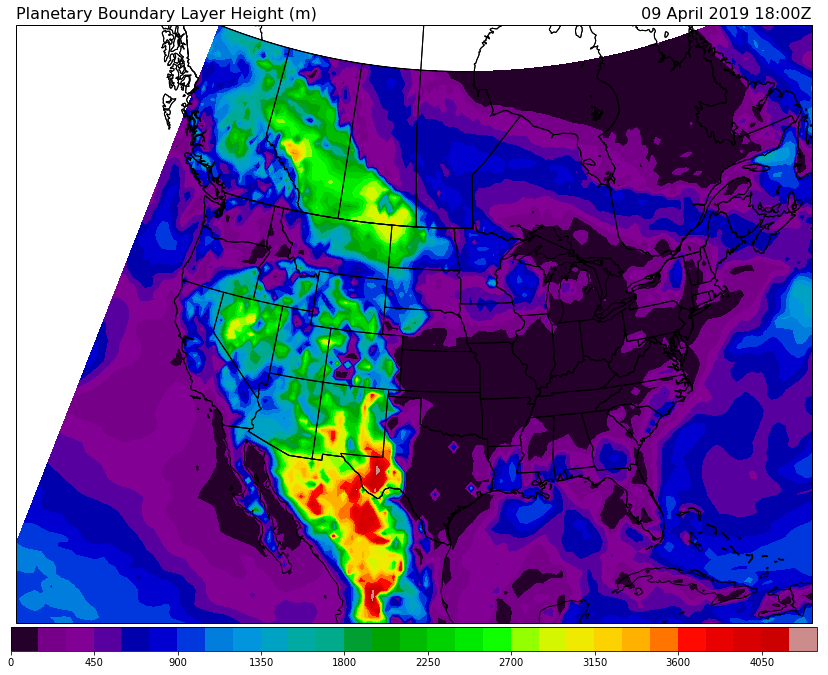

In [257]:
# Create a plot
fig = plt.figure(figsize=(17., 11.))

add_metpy_logo(fig, 30, 940, size='small')

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    
# Plot Title
plt.title("Planetary Boundary Layer Height (m)",loc='left',fontsize=16)
plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)



                                            # Isentropic Winds
#---------------------------------------------------------------------------------------------------
print("ok.")
lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
#lon[lon_slice], lat[lat_slice],
#         isen_u[lon_slice, lat_slice],
#         isen_v[lon_slice, lat_slice],
lon_2d, lat_2d = np.meshgrid(lon, lat)
#ax.barbs(lon,lat,Q[0][0,:,:], Q[1][0,:,:], 
#         transform=ccrs.PlateCarree(), zorder=3,barbcolor='k')
#ax.quiver(lon[lon_slice],lat[lat_slice],Q[0][0,lon_slice,lat_slice], Q[1][0,lon_slice,lat_slice],color='k',
#          transform=plotcrs)


#ax.quiver(lon[110],lat[40],Q[0][0,40,11], Q[1][0,40,11],color='r',transform=plotcrs)
#ax.quiver(lon[110],lat[40],Q[0][0,40,110], Q[1][0,40,110],transform=plotcrs,color='r')

#ax.quiver(lon[112],lat[32],Q[0][0,32,112], Q[1][0,32,112],transform=plotcrs)
#clev = np.arange(Fronto.min().m,Fronto.max().m, .0000000001)

# Uncomment for contours instead of contour fill (below)
#cs2 = ax.contour(lon_2d, lat_2d, temp.to(units('degF')), clevtemp,
#                 cmap='gist_rainbow_r', linewidths=1.25,
#                 transform=datacrs)  #linestyles='dotted'

#cs2 = ax.contour(lon, lat, temp.to(units('degF')),40,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)


cs2 = ax.contourf(lon, lat, zero_isotherm,40,
                 transform=datacrs,cmap="nipy_spectral") #'nipy_spectral'
#cs2 = plt.pcolormesh(lon, lat, cape,
#                 transform=datacrs,cmap='nipy_spectral',alpha=0.5)

ax.set_extent(extent, datacrs)

cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)

plt.show()


#GFS_Isentrope = im_save_path+"GFS/Isentropes_MixRatio/"
#if not os.path.isdir(GFS_Isentrope):
#os.makedirs(GFS_Isentrope)
fig.savefig("/Users/chowdahead/Desktop/PBL_heights.png",bbox_inches='tight',dpi=120)
#plt.close(fig)